In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
def binary_confusion_matrix(y, y_hat, as_pct=False, verbose=True):
    cm = pd.DataFrame(confusion_matrix(y, y_hat), 
                      columns=['(+) actual', '(-) actual'],
                      index=['(+) predicted', '(-) predicted'])
    if as_pct:
        cm = cm / cm.sum().sum()
        
    P = cm['(+) actual'].sum()
    N = cm['(-) actual'].sum()
    total = P + N
    TP = cm.loc['(+) predicted', '(+) actual']
    FP = cm.loc['(+) predicted', '(-) actual']
    TN = cm.loc['(-) predicted', '(-) actual']
    FN = cm.loc['(-) predicted', '(+) actual']
    TPR = TP / (TP + FN)          # recall/sensitivity
    TNR = TN / (TN + FP)   # specificity
    FPR = FP / (FP + TN)   # fall-out
    FNR = FN / (FN + TP)   # miss rate
    PPV = TP / (TP + FP)   # precision
    NPV = TN / (TN + FN)   # neg predictive value
    
    if verbose:
        print('''
        Condition Positive:                        %i
        Condition Negative:                        %i
        Total Observations:                        %i
        
        True Positive:                             %i
        True Negative:                             %i
        False Positive:                            %i
        False Negative                             %i
        
        True Positive Rate (recall):               %.2f%%
        True Negative Rate (specificity):          %.2f%%
        False Positive Rate (fall-out):            %.2f%%
        False Negative Rate (miss rate):           %.2f%%
        
        Positive Predictive Value (precision):     %.2f%%
        Negative Predictive Value:                 %.2f%%
        ''' %(P, N, total,
             TP, TN, FP, FN,
             TPR*100, TNR*100, FPR*100, FNR*100, 
             PPV*100, NPV*100))
        
    metrics = {'P': P, 'N': N, 'total': total, 
              'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
              'TPR': TPR, 'TNR': TNR, 'FPR': FPR, 'FNR': FNR, 'PPV': PPV, 'NPV': NPV}
    
    return cm, metrics



class ColumnExtractor(BaseEstimator, TransformerMixin):
    '''
    Transformer for extracting columns in sklearn pipeline
    '''
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols
    
class LabelEncodeObjects(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        assert isinstance(data, pd.DataFrame)
        data = data.astype(str)
        data = data.apply(LabelEncoder().fit_transform)
        return data
    
class DenseTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
   

def correlation_heatmap(df, cutoff=None, title=''):
    df_corr = df.corr('pearson')
    np.fill_diagonal(df_corr.values, 0)
    if cutoff != None:
        for col in df_corr.columns.tolist():
            df_corr.loc[df_corr[col].abs() <= cutoff, col] = 0
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_corr, ax=ax, cmap='RdBu_r')
    plt.suptitle(title, size=18)
    plt.show()
    return df_corr

In [6]:
train_df = pd.read_csv('data/train_data.csv')
train_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,...,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,...,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,...,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,...,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,...,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


In [7]:
train_df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z215,z216,z217,z218,z219,z220,z221,z222,phase,output
count,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,...,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.0,0.000218,0.000218,0.625436,-270.199043,1.801323,-4.654634,253.735831,0.021039,-0.000004,...,-0.001628,0.001754,0.001374,0.001404,-57.916190,96.554052,-52.630948,28.735112,2.519634,0.844895
std,0.0,0.014770,0.014770,0.484063,163.971643,1.143173,3.714967,147.405918,0.026384,0.000472,...,0.099405,0.070156,0.078443,0.091211,243.742549,597.912778,599.208382,217.842477,1.158998,0.362044
min,0.0,0.000000,0.000000,0.000000,-474.588020,-0.237454,-19.295360,0.026692,0.005007,-0.004008,...,-3.805788,-0.999448,-1.886137,-1.264762,-2182.646032,-6674.270678,-8311.046315,-3671.954955,1.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,-383.328439,0.815996,-6.708809,108.809493,0.007504,-0.000081,...,-0.022183,-0.018118,-0.017379,-0.021389,-31.817506,-1.715924,-11.180312,-0.050475,1.000000,1.000000
50%,0.0,0.000000,0.000000,1.000000,-351.317222,1.578367,-3.324030,313.157669,0.011282,0.000003,...,-0.000383,0.000673,0.000374,0.000507,-2.919292,0.098110,-0.492411,0.001721,3.000000,1.000000
75%,0.0,0.000000,0.000000,1.000000,-177.051209,2.741501,-2.027700,370.832095,0.021861,0.000083,...,0.020556,0.020727,0.019355,0.022440,-0.277689,13.684733,-0.032526,0.483496,4.000000,1.000000
max,0.0,1.000000,1.000000,1.000000,418.085156,4.368496,6.250661,588.309282,0.423408,0.003588,...,0.916725,0.708321,1.548114,2.949784,2408.234281,6111.797852,6412.126601,2816.376179,4.000000,1.000000


In [8]:
train_df.shape

(4584, 670)

In [9]:
train_df.isnull().sum().sum()

0

In [10]:
train_df['output'].value_counts() / train_df.shape[0]

1    0.844895
0    0.155105
Name: output, dtype: float64

## Exploratory Analysis

In [14]:
# specify columns
y_col = ['output']
cat_cols = ['subject', 'phase', 'state', 'x1', 'x2', 'x3', 'x4']
num_cols = [col for col in train_df.columns if col not in cat_cols+y_col]
X_cols = cat_cols + num_cols

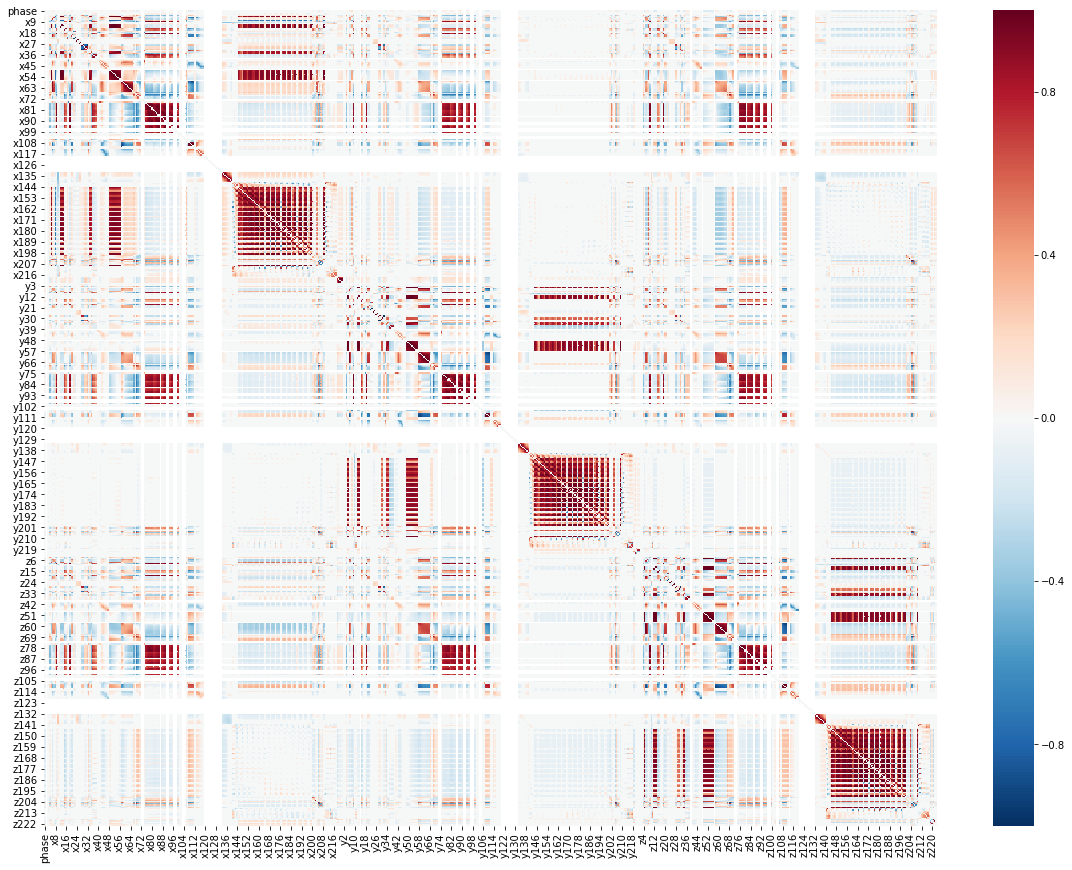

In [15]:
plot_cols = X_cols + y_col
_ = correlation_heatmap(train_df[plot_cols], cutoff=.05)

# Fit baseline model with `LogisticRegression`

In [16]:
# split data
X, y = train_df[X_cols], train_df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)#, stratify=y)


pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('clf', LogisticRegression())
])
     
# fit pipeline
pipeline.fit(X_train, y_train)

# get metrics 
y_pred_train, y_pred_test = pipeline.predict(X_train), pipeline.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))


Training Accuracy = 0.8833
Validation Accuracy = 0.8321

Training F1 Score = 0.9335
Validation F1 Score = 0.9039



In [17]:
cm, metrics = binary_confusion_matrix(y_test, pipeline.predict(X_test))
cm


        Condition Positive:                        94
        Condition Negative:                        823
        Total Observations:                        917
        
        True Positive:                             39
        True Negative:                             724
        False Positive:                            99
        False Negative                             55
        
        True Positive Rate (recall):               41.49%
        True Negative Rate (specificity):          87.97%
        False Positive Rate (fall-out):            12.03%
        False Negative Rate (miss rate):           58.51%
        
        Positive Predictive Value (precision):     28.26%
        Negative Predictive Value:                 92.94%
        


,(+) actual,(-) actual
(+) predicted,39,99
(-) predicted,55,724


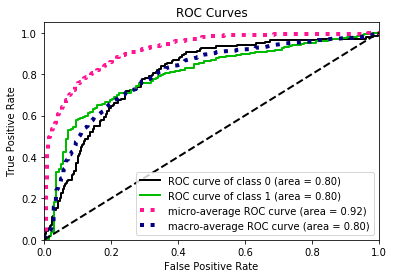

In [18]:
skplt.metrics.plot_roc_curve(y_test, pipeline.predict_proba(X_test))

# Test `RandomForestClassifier` with `GridSearchCV`

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'clf__n_estimators': [1000],
         'clf__max_depth': [100], 
         'clf__max_features': [.5]}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('clf', RandomForestClassifier())
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 13.7min finished


Best Model
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training Accuracy = 1.0000
Validation Accuracy = 0.8702

Training F1 Score = 1.0000
Validation F1 Score = 0.9261



In [20]:
cm, metrics = binary_confusion_matrix(y_test, y_pred_test)
cm


        Condition Positive:                        85
        Condition Negative:                        832
        Total Observations:                        917
        
        True Positive:                             52
        True Negative:                             746
        False Positive:                            86
        False Negative                             33
        
        True Positive Rate (recall):               61.18%
        True Negative Rate (specificity):          89.66%
        False Positive Rate (fall-out):            10.34%
        False Negative Rate (miss rate):           38.82%
        
        Positive Predictive Value (precision):     37.68%
        Negative Predictive Value:                 95.76%
        


,(+) actual,(-) actual
(+) predicted,52,86
(-) predicted,33,746


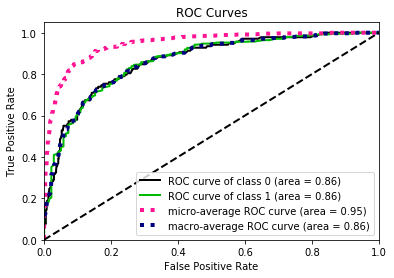

In [21]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [22]:
rf_params = grid.best_estimator_.named_steps['clf'].get_params()

In [23]:
# retrain model on full dataset
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('clf', RandomForestClassifier(**rf_params))
])
     
# fit pipeline
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(cols=['x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [24]:
test_df = pd.read_csv('data/test_data.csv')
X = test_df[X_cols]
X.head()

,subject,phase,state,x1,x2,x3,x4,x5,x6,x7,...,z213,z214,z215,z216,z217,z218,z219,z220,z221,z222
0,E,4,D,0,0,0,1,4.665949,0.083412,-17.397081,...,0.024480,-0.017457,0.004269,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290
1,H,4,D,0,0,0,0,-398.299487,0.784032,-10.785768,...,0.024129,0.096665,-0.064644,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017
2,C,4,B,0,0,0,1,-380.902140,0.671324,-9.265829,...,-0.044228,-0.014212,0.001407,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553
3,H,1,C,0,0,0,1,-342.784123,0.469414,-8.044287,...,-0.026939,-0.018544,-0.010918,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359
4,E,4,B,0,0,0,1,6.248502,0.252336,-5.398056,...,0.020188,0.012222,0.002305,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150


In [25]:
y_pred = pipeline.predict(X)
pd.Series(y_pred).to_csv('data/predictions.csv')

Score on Kaggle was 0.488.

# Test `SVC` with `GridSearchCV`

In [ ]:


params = {'clf__C': [.001, .01, .1, 1, 10, 100, 1000],
         'clf__probability': [True]}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('clf', SVC())
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [ ]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [ ]:
svc_params = grid.best_estimator_.named_steps['clf'].get_params()
svc_params

## Try Augmenting with `SelectKBest`

In [67]:
X.shape

(1732, 669)

In [68]:
from sklearn.feature_selection import SelectKBest

k_list = [k for k in np.arange(25, 500, 50)]
params = {'select__k': k_list}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('select', SelectKBest()),
    ('clf', SVC(**svc_params))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Best Model
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Training Accuracy = 0.8572
Validation Accuracy = 0.8503

Training F1 Score = 0.9221
Validation F1 Score = 0.9186



In [69]:
grid.best_estimator_.named_steps['select']

SelectKBest(k=275, score_func=<function f_classif at 0x1a1c0b8e18>)

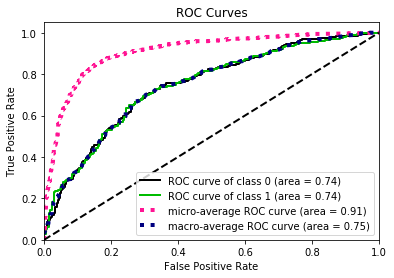

In [70]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [72]:
y_pred = grid.predict(X)
pd.Series(y_pred).to_csv('data/svc_kbest_predictions.csv')

# Test `PCA` with `RandomForestClassifier`

In [81]:
params = {'pca__n_components': [.7, .8, .95, None]}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('pca', PCA()),
    ('clf', RandomForestClassifier(**rf_params))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.4min remaining:   41.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.5min finished


Best Model
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training Accuracy = 1.0000
Validation Accuracy = 0.8488

Training F1 Score = 1.0000
Validation F1 Score = 0.9174



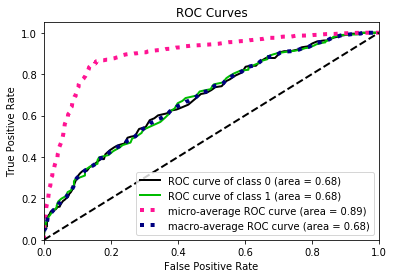

In [82]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [85]:
pca_params = grid.best_estimator_.named_steps['pca'].get_params()
pca_params

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 0.7,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [89]:
X, y = train_df[X_cols], train_df[y_col]

# retrain on full data
# retrain model on full dataset
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('pca', PCA(**pca_params)),
    ('clf', RandomForestClassifier(**rf_params))
])
     
# fit pipeline
pipeline.fit(X, y)

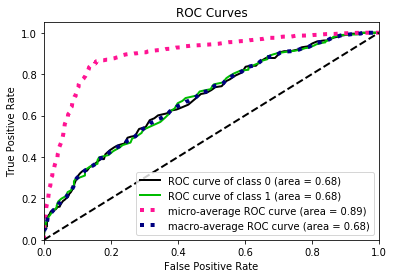

In [90]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [91]:
test_df = pd.read_csv('data/test_data.csv')
X = test_df[X_cols]
y_pred = pipeline.predict(X)
pd.Series(y_pred).to_csv('data/rf_pca_predictions.csv')

Best so far: .53 accuracy

# Test `KNeighborsClassifier`

In [96]:
from sklearn.neighbors import KNeighborsClassifier

params = {'pca__n_components': [.7, .8, .95, None],
         'clf__n_neighbors': [8, 16, 32, 64, 128, 256]}

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('pca', PCA()),
    ('clf', KNeighborsClassifier())
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.1min finished


Best Model
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform')

Training Accuracy = 0.8563
Validation Accuracy = 0.8488

Training F1 Score = 0.9212
Validation F1 Score = 0.9174



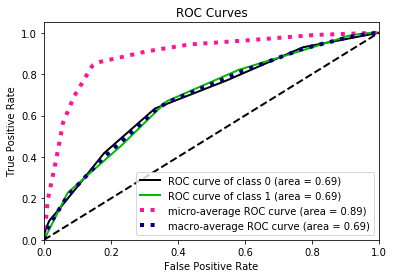

In [97]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

# Test Stacked Classifier

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

params = {'pca__n_components': [.7, .8, .95, None]}

clfs = [KNeighborsClassifier(n_neighbors=32), 
        RandomForestClassifier(**rf_params),
        GaussianNB(),
        LogisticRegression(),
        SVC(**svc_params)]

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('pca', PCA()),
    ('clf', StackingClassifier(classifiers=clfs, 
                               meta_classifier=KNeighborsClassifier(n_neighbors=32)))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  4.1min remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.2min finished


Best Model
StackingClassifier(average_probas=False,
          classifiers=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=32, p=2,
           weights='uniform'), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=0.75,...f',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
          meta_classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=32, p=2,
           weights='uniform'),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

Training Accuracy = 1.0000
Validation Accuracy = 0.8488

Training F1 Score = 1.0000
Validation F1 Score = 0.9175



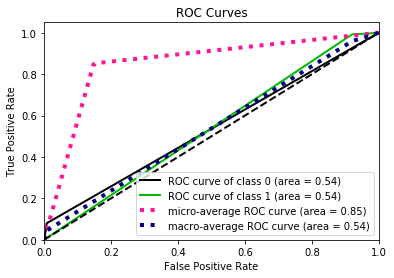

In [116]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

# Test `AdaBoostClassifier(DecisionTreeClassifier)` Alone

In [124]:
params = {'pca__n_components': [.7, .8, .95, None]}

clfs = [KNeighborsClassifier(n_neighbors=32), 
        RandomForestClassifier(**rf_params),
        GaussianNB(),
        LogisticRegression(),
        SVC(**svc_params)]

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('pca', PCA()),
    ('clf', AdaBoostClassifier(LogisticRegression(C=100)))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   44.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   45.1s finished


Best Model
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

Training Accuracy = 0.8432
Validation Accuracy = 0.8451

Training F1 Score = 0.9149
Validation F1 Score = 0.9161



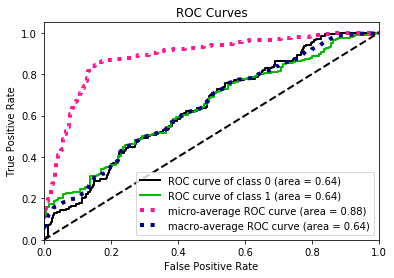

In [125]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

params = {}

clfs = [KNeighborsClassifier(n_neighbors=32), 
        RandomForestClassifier(**rf_params),
        GaussianNB(),
        LogisticRegression(),
        SVC(**svc_params)]

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    #('pca', PCA()),
    ('clf', StackingClassifier(classifiers=clfs, 
                               meta_classifier=KNeighborsClassifier(n_neighbors=32)))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.3min finished


Best Model
StackingClassifier(average_probas=False,
          classifiers=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=32, p=2,
           weights='uniform'), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=0.75,...f',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
          meta_classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=32, p=2,
           weights='uniform'),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

Training Accuracy = 0.9978
Validation Accuracy = 0.8626

Training F1 Score = 0.9987
Validation F1 Score = 0.9226



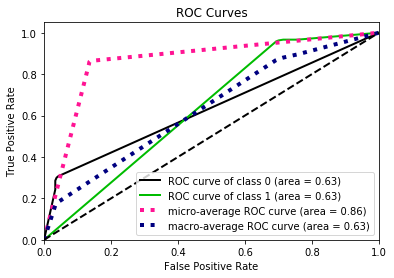

In [131]:
skplt.metrics.plot_roc_curve(y_test, grid.predict_proba(X_test))

In [133]:
X = test_df[X_cols]
y_pred = grid.predict(X)
pd.Series(y_pred).to_csv('data/stack_knn_predictions.csv')

Model deteriorated to .488.

# Test `FastICA`

In [30]:
from sklearn.decomposition import FastICA

params = {'ica__n_components': [.7, .8, .95, None]}

clfs = [KNeighborsClassifier(n_neighbors=32), 
        RandomForestClassifier(**rf_params),
        GaussianNB(),
        LogisticRegression(),
        SVC(**svc_params)]

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnExtractor(num_cols)),
            ('scale', StandardScaler())
        ])),
        ('factors', Pipeline([
            ('extract', ColumnExtractor(cat_cols)),
            ('label', LabelEncodeObjects()),
            ('encode', OneHotEncoder(handle_unknown='ignore'))
        ]))
    ])),
    ('dense', DenseTransformer()),
    ('ica', FastICA()),
    ('clf', StackingClassifier(classifiers=clfs, 
                               meta_classifier=KNeighborsClassifier(n_neighbors=32)))
])
     
# grid search to fit pipeline
grid = GridSearchCV(pipeline, params, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

# check best
print('Best Model')
print(grid.best_estimator_.named_steps['clf'])

# get metrics 
y_pred_train, y_pred_test = grid.predict(X_train), grid.predict(X_test)
val_acc, val_f1 = accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test)
train_acc, train_f1 = accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train)

print('''
Training Accuracy = %.4f
Validation Accuracy = %.4f

Training F1 Score = %.4f
Validation F1 Score = %.4f
''' %(train_acc, val_acc, train_f1, val_f1))

NameError: name 'svc_params' is not defined